Smote technique to optimize imbalanced data set

· Baseline classification model – logistic regression & K-nearest

· XG-Boost model – tune parameters via grid search

· Lean into imbalance data set thing and anomaly detection

Anomaly detection ideas:

- Auto encoder
- DB scan


· Maybe correlate time feature

In [1]:
# pip install opendatasets

import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split

# %matplotlib
pd.set_option('display.max_columns', None)

### Load Data 

- retreived from kaggle portal
- File too large to store in github

In [3]:
dataset_url="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data"

od.download(dataset_url)

Skipping, found downloaded files in ".\creditcardfraud" (use force=True to force download)


In [4]:
data_dir = "creditcardfraud"

os.listdir(data_dir)

['creditcard.csv']

In [5]:
creditcard=data_dir + "/creditcard.csv"
data = pd.read_csv(creditcard)

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
prop = 492/ 284315
round(prop, 3)

0.002

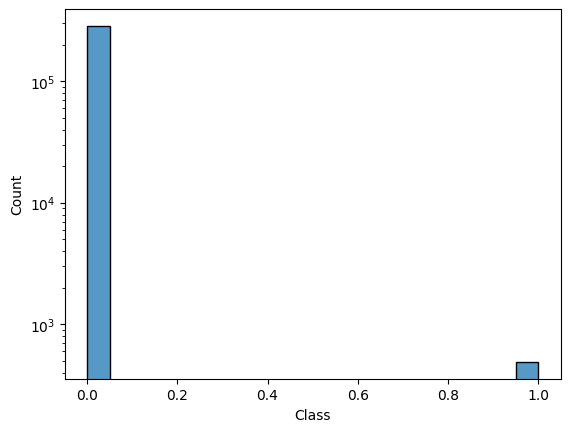

In [8]:
#data imbalance
sns.histplot(data['Class'])
plt.yscale('log')
plt.show()


In [9]:
data.groupby('Class')['Amount'].sum()

Class
0    25102462.04
1       60127.97
Name: Amount, dtype: float64

<Axes: xlabel='Amount', ylabel='Class'>

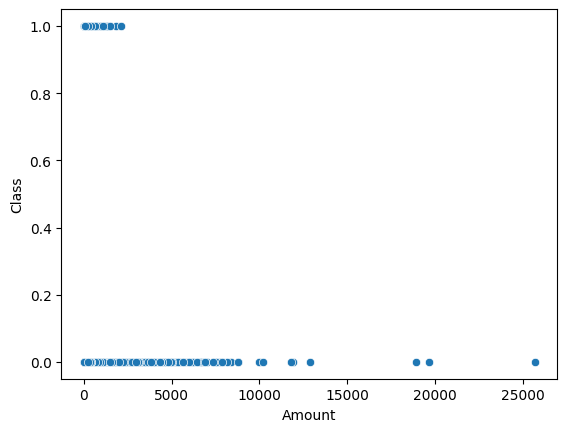

In [10]:
amountClass = data[["Amount", "Class"]]
sns.scatterplot(amountClass, x = "Amount", y= "Class")

Bringing Amount and Time into the same scale as the rest of the column as not in give a single feature dominance over the other. 

In [6]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()
features_to_scale = ['Amount', 'Time']

data[features_to_scale] = rob_scaler.fit_transform(data[features_to_scale])
data.rename(columns={feature: f'scaled_{feature}' for feature in features_to_scale}, inplace=True)
data.head()

,scaled_Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,scaled_Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0


In [12]:
# in our case we may want to have detecting fraud as TP for confusion Matrix, this will allow that to happen
# data["Class"] = data["Class"].apply(lambda x: 1 if x == 0 else 0)

In [7]:
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (227845, 30)
y_train shape: (227845,)
X_train type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>


# Confusion Matrix Overview

TP  FP 

FN  TN

*TP:* Transaction is truly fraud

*FP:* Transcation flagged as fraud when it actually wasn't

*TN:* Transaction was not flagged for fraud and it is not a fradulent transaction

*FN:* Transaction was not flagged for fraud but it is fraulent

# Supervised Learning Model

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
def report(y_test, mod):
    # Evaluate performance using classification report
    print(classification_report(y_test, mod))

    # Evaluate performance using confusion matrix
    print(confusion_matrix(y_test, mod))

    

In [17]:
# Base model
lgm = LogisticRegression(solver='liblinear', random_state=42)
lgm.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

**Hyperparameters**

solver: {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’

- lbfgs: relatively good perform (may have issues with convergence)
- sag: faster than other for large datasets, when both the number of samples and the number of features are large
- saga: sparse multinomial logistic regression and suitable for very large datasets
- newton-cg: computationally expensive because of the Hessian Matrix
- liblinear: recommended for high dimension dataset - solving large-scale classification problems

penalty: {‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’

tol: tolerance to stopping (early stopping)

C: regularization strength

dual:

fit_intercept:

intercept_scaling:

class_weight: 

max_iter:

verbose:

warm_start:

n_jobs:

l1_ratio:

In [18]:
lgm.classes_

array([0, 1], dtype=int64)

In [19]:
y_pred = lgm.predict(X_test)

report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

[[56855     9]
 [   41    57]]


True:    284315

Fraudulent:       492

## K-Nearest Neighbor

**haven't gotten it to run correctly yet**

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56860     4]
 [   23    75]]


## XGBoost

XGBoost: Extreme Gradient Boost is distributed-boosted gradient tree. 

- improves a single weak model by combining it with a number of other weak models to generate a collectively strong model

**xgb.train():**
- lower-level function in XGBoost that allows you to train a gradient boosting model with fine-grained control over parameters
- It requires you to explicitly define the model parameters
- Need to prepare the data beforehand and pass it to the function as DMatrix objects


- Pro: More flexibility and customization optionss
- Con: ore manual intervention and tuning

In [21]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings

In [22]:
warnings.filterwarnings("ignore")

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 5,                # Number of classes
    'eta': 0.01,                   # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'min_child_weight': 1,         # Minimum sum of instance weight required in a child
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.6,       # Subsample ratio of columns when constructing each tree
    'gamma': 0.3,                  # Minimum loss reduction required to make a further partition on a leaf node
    'lambda': 0.6,                 # L2 regularization term on weights
    'alpha': 0.2,                  # L1 regularization term on weights
    'scale_pos_weight': 0.4,       # Control the balance of positive and negative weights
    'tree_method': 'auto',       # Tree construction algorithm
    'grow_policy': 'lossguide'  
}

# Convert data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the XGBoost model
epochs = 100
bst = xgb.train(params, dtrain, epochs)

# Predictions
preds = bst.predict(dtest)

# Calculate accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)


Accuracy: 0.9995259997893332


In [23]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.73      0.84        98

    accuracy                           1.00     56962
   macro avg       0.99      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56863     1]
 [   26    72]]


**XGBClassifier():**
- Higher-level interface for classification tasks
- Follows the same API conventions as other classifiers in scikit-learn, (easier to use within scikit-learn pipelines and workflows)
- Handles many details internally (data preprocessing, model initialization, and parameter tuning) 
- You can directly pass the raw data (features and labels) to XGBClassifier()

In [24]:
warnings.filterwarnings("ignore")

# fit model no training data
xgc = XGBClassifier()
xgc.fit(X_train, y_train)

print(xgc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [25]:
y_pred = xgc.predict(X_test)
predictions = [round(value) for value in y_pred]

report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[[56861     3]
 [   22    76]]


In [26]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.96%


# GridSearch Example

In [27]:
xgc = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator= xgc, param_grid= param_grid, cv= 3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters on the test set
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Test Accuracy with Best Hyperparameters:", accuracy)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Test Accuracy with Best Hyperparameters: 0.9995962220427653


# SMOTE

SMOTE(*, 

*sampling_strategy*= float (only for binary), str (in our casue will use either auto or minority), dict or callable, default=’auto’,  

*random_state*= controls randomization, 

*k_neighbors*= define the neighborhood of samples
)

In [29]:
# in terminal: conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
counter = Counter(y_train_resampled)
counter

Counter({0: 227451, 1: 227451})

For Logistic Regression

In [30]:
lgm = LogisticRegression(solver='liblinear', random_state=42)
lgm.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.80      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

[[56861     3]
 [   20    78]]


SMOTE on XGBoost Classifier

In [ ]:
# fit model no training data
xgc = XGBClassifier()
xgc.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.80      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

[[56861     3]
 [   20    78]]


**Play Around With SMOTE**

# Boarderline SMOTE

Similar to ADASYN, looks at minority points that are on the boarder (and creates an imaginay line) with the majority points and creates more minority points along the imaginary lines


BoarderlineSMOTE(*, 

sampling_strategy= float, str, dict or callable, default=’auto’, 

random_state= Control the randomization , 

k_neighbors= used to define the neighborhood of samples, 

m_neighbors= The nearest neighbors used to determine if a minority sample is in “danger”., 

kind='borderline-1' or 'borderline-2')
- boarderline-1: oversampling along border for both classes
- boarderline-2: oversampling along boarder for **minority class**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42, kind= 'borderline-2')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
counter = Counter(y_train_resampled)

# fit model no training data
xgc = XGBClassifier()
xgc.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.80      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

[[56861     3]
 [   20    78]]


In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42, k_neighbors= 7, m_neighbors= 5, kind= 'borderline-2')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
counter = Counter(y_train_resampled)

# fit model no training data
model = XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56851    13]
 [   17    81]]


# ADASYN

increases minority observations and placing more weights near observations that are more difficult to classify

- if points are next to points of the different classification then ADASYN will ad more minority classification points in this area

In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42,  n_neighbors= 3) 
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

model = XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.86      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56840    24]
 [   14    84]]


In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42) 
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

model = XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

report(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.86      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962

[[56835    29]
 [   14    84]]


GridSearch after ADASYN oversampling method

In [ ]:
model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator= model, param_grid= param_grid, cv= 3, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters on the test set
model = XGBClassifier(**best_params)
model.fit(X_train_resampled, y_train_resampled)
accuracy = model.score(X_test, y_test)
print("Test Accuracy with Best Hyperparameters:", accuracy)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Test Accuracy with Best Hyperparameters: 0.997542221129876


# Anomoly Detection

## DBSCAN

**may not be best for high dimensional datasets**

- eps = distance between two samples
- min_samples = minimal sample in neigbhorhood

<Axes: xlabel='Time', ylabel='Count'>

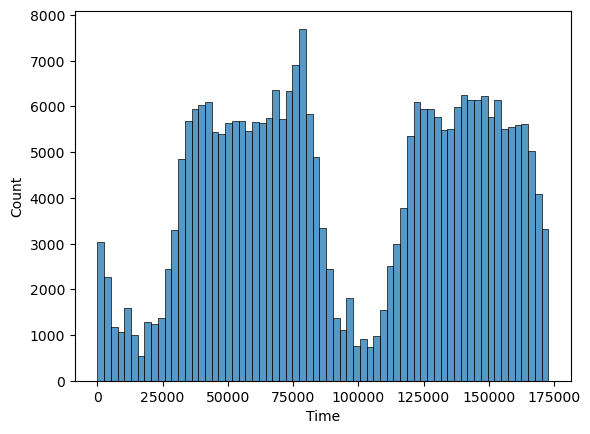

In [ ]:
sns.histplot(data["Time"])

In [8]:
# combine X_train_resampled and y_train_resampled into one df
dbscan_train = pd.concat([X_train_resampled, y_train_resampled], axis=1)



NameError: name 'X_train_resampled' is not defined

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
from sklearn.decomposition import PCA

# Assuming that data_scaled is your standardized data
pca = PCA(n_components=2)  # Reduce the data to 2 dimensions
data_pca = pca.fit_transform(data_scaled)

# Apply DBSCAN to the reduced data
dbscan = DBSCAN(eps=15, min_samples=20)
clusters = dbscan.fit_predict(data_pca)

# Identify the core samples
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Label -1 is considered as noise by the DBSCAN algorithm
# So, anomalies are the data points not part of any clusters (noise)
anomalies = data[clusters == -1]

print('Number of anomalies detected:', len(anomalies))

MemoryError: 